# Risk Adjustment
In this notebook we risk adjusted readmission rate for each hospital. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#import statsmodels.api as sm
from sklearn.model_selection import train_test_split, StratifiedKFold, GroupShuffleSplit
from sklearn.metrics import roc_curve, auc
import os, sys, time
from importlib import reload
%matplotlib inline

In [2]:
os.environ['CUDA_VISIBLE_DEVICES'] = ''

In [2]:
path = '/nfs/turbo/intmed-bnallamo-turbo/wsliu/Data/NRD/'

In [2]:
path = '/nfs/turbo/umms-awaljee/wsliu/Data/NRD/'

In [3]:
model_path = path + 'models/'
if not os.path.exists(model_path): os.mkdir(model_path)

In [5]:
from keras.layers import Input, Embedding, Concatenate, Reshape, BatchNormalization, LSTM, CuDNNLSTM, CuDNNGRU, Lambda
from keras.models import Model
from keras.layers.core import Dense, Activation, Dropout, RepeatVector
from keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping
from keras.utils import to_categorical
from keras.optimizers import Adam
from keras.initializers import Constant
import keras.backend as K

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)
from DL_utils import plot_roc
from keras_addon import AUCCheckPoint
from utils import get_frequency, preprocess

Using TensorFlow backend.


In [4]:
from ccs_tools import dx_multi, pr_multi, core_dtypes_pd

## Risk Adjustment for LME

In [5]:
cohort = 'ami'

In [35]:
adjust_df = pd.read_csv(path+'cohorts30/'+cohort+'/adjustment0.csv')

In [36]:
adjust_df.head()

,Unnamed: 0,KEY_NRD,HOSP_NRD,readm30,predicted_score,expected_score
0,1,10576754,12929,0,0.144287,0.160403
1,2,19785198,12175,0,0.108129,0.109399
2,3,19212175,12024,0,0.065265,0.063018
3,4,21012648,12307,0,0.050514,0.060656
4,5,18432816,12245,1,0.526640,0.493377


In [37]:
national_rate = adjust_df.readm30.mean()

In [38]:
grouped = adjust_df.groupby('HOSP_NRD')

adjusted_rate = grouped[['readm30', 'predicted_score', 'expected_score']].mean()

adjusted_rate = adjusted_rate.assign(N=grouped.size())

adjusted_rate.columns = ['Observed', 'Predicted_ME', 'Expected_ME', 'N']

adjusted_rate = adjusted_rate.assign(Adjusted_ME=adjusted_rate.Predicted_ME/adjusted_rate.Expected_ME*national_rate)

In [40]:
adjusted_rate = adjusted_rate.reset_index()

In [64]:
adjusted_rate = adjusted_rate.sort_values(by='N', ascending=False)

In [126]:
national_rate

0.12522119288019154

In [12]:
recycle_ME = pd.read_csv(path+'cohorts/{}/recycled_ME.csv'.format(cohort))

In [14]:
adjusted_rate = pd.merge(adjusted_rate, recycle_ME, on='HOSP_NRD')

In [30]:
adjusted_rate.head(10)

,HOSP_NRD,Observed,Predicted_ME,Expected_ME,N,Adjusted_ME
0,11006,0.101695,0.104802,0.116916,177,0.112310
1,11010,0.088942,0.099941,0.111879,416,0.111923
2,11011,0.098592,0.168983,0.195666,71,0.108206
3,11013,0.206972,0.182855,0.139360,459,0.164397
4,11014,0.097245,0.105771,0.114268,617,0.115976
5,11021,0.054598,0.078371,0.105035,348,0.093485
6,11022,0.107246,0.108931,0.109472,345,0.124674
7,11024,0.222222,0.201061,0.195052,36,0.129152
8,11029,0.145299,0.144546,0.134235,234,0.134916
9,11032,0.111913,0.113414,0.111619,277,0.127308


In [134]:
adjusted_rate = adjusted_rate.reset_index()

In [85]:
intercept = pd.read_csv(path+'cohorts/{}/intercepts0.csv'.format(cohort))

In [87]:
intercept.columns = ['HOSP_NRD', 'intercept', 'AGE']

In [122]:
adjusted_rate0 = adjusted_rate.copy()

In [155]:
compare = pd.merge(adjusted_rate[['HOSP_NRD', 'Adjusted_ME']], intercept[['HOSP_NRD', 'intercept']], on='HOSP_NRD')

In [135]:
compare = pd.merge(adjusted_rate0[['HOSP_NRD', 'Adjusted_ME', 'N']], adjusted_rate[['HOSP_NRD', 'Adjusted_ME']], on='HOSP_NRD', 
                   suffixes=('_index', '_tst'))

In [136]:
compare.head()

,HOSP_NRD,Adjusted_ME_index,N,Adjusted_ME_tst
0,11006,0.113181,177,0.111927
1,11010,0.112333,416,0.110971
2,11011,0.109424,71,0.108452
3,11013,0.164535,459,0.162695
4,11014,0.116193,617,0.115157


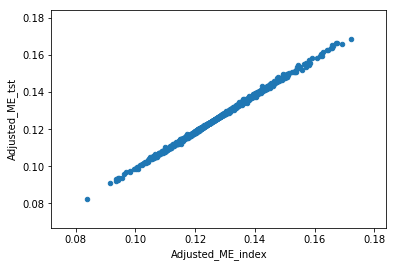

In [137]:
compare.plot.scatter('Adjusted_ME_index', 'Adjusted_ME_tst')

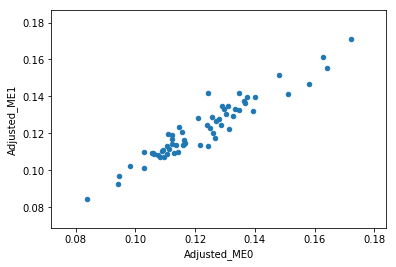

In [79]:
compare.loc[compare.N>50].plot.scatter('Adjusted_ME0', 'Adjusted_ME1')

In [92]:
compare = compare.sort_values('intercept')
compare = compare.assign(intercept_rank = range(len(compare)))

In [109]:
compare = compare.assign(Division_y = 'middle60')
compare.loc[compare.Rank_y<int(len(compare)*0.2), 'Division_y'] = 'top20'
compare.loc[compare.Rank_y>int(len(compare)*0.8), 'Division_y'] = 'bottom20'

In [149]:
recycle_ME_index = pd.read_csv(path+'cohorts/{}/recycled_ME.csv'.format(cohort))

In [150]:
recycle_ME_tst = pd.read_csv(path+'cohorts/{}/recycled_ME_tst0.csv'.format(cohort))

In [152]:
compare = pd.merge(recycle_ME_index, recycle_ME_tst, on='HOSP_NRD')

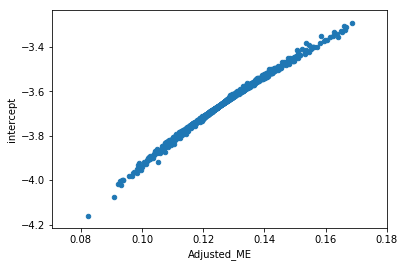

In [156]:
compare.plot.scatter('Adjusted_ME', 'intercept')

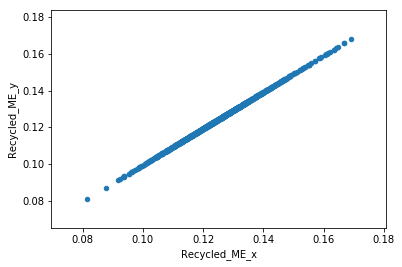

In [154]:
compare.plot.scatter('Recycled_ME_x', 'Recycled_ME_y')

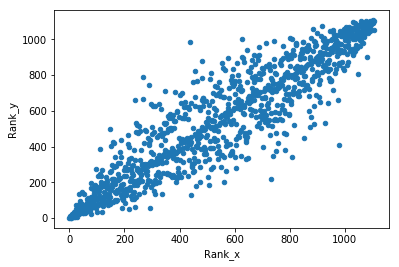

In [110]:
compare.plot.scatter('Rank_x', 'Rank_y')

In [111]:
pd.crosstab(compare.Division_x, compare.Division_y, margins=True)

Division_y,bottom20,middle60,top20,All
Division_x,,,,
bottom20,172,49,0,221
middle60,49,577,39,665
top20,0,39,182,221
All,221,665,221,1107


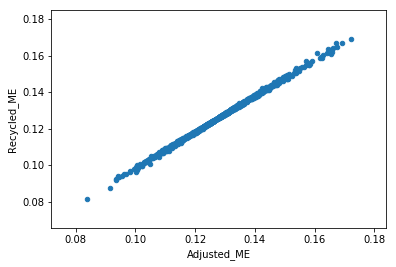

In [16]:
adjusted_rate.plot.scatter('Adjusted_ME', 'Recycled_ME')

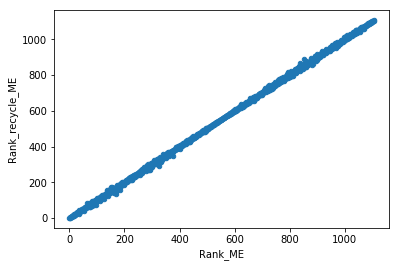

In [22]:
adjusted_rate.plot.scatter('Rank_ME', 'Rank_recycle_ME')

In [23]:
pd.crosstab(adjusted_rate.Division_ME, adjusted_rate.Division_recycle_ME, margins=True)

Division_recycle_ME,bottom20,middle60,top20,All
Division_ME,,,,
bottom20,216,5,0,221
middle60,5,655,5,665
top20,0,5,216,221
All,221,665,221,1107


## Risk Adjustment for DL

In [13]:
cohort='pna'
tst_seed=0

In [14]:
index_df = pd.read_csv(path+'cohorts30/{}/index_comorb.csv'.format(cohort), dtype=core_dtypes_pd)

In [15]:
index_df.readm30.mean()

0.16028492313089673

In [47]:
tst_df = pd.read_csv(path+'cohorts30/{}/tst{}.csv'.format(cohort, tst_seed), dtype=core_dtypes_pd)

In [118]:
index_df.shape

(187274, 183)

In [120]:
split1, split2 = train_test_split(index_df, test_size=0.5, random_state=24, stratify=index_df.HOSP_NRD)

In [122]:
split1.shape, split2.shape

((93637, 183), (93637, 183))

In [127]:
for j in range(10):
    split1, split2 = train_test_split(index_df, test_size=0.5, random_state=j, stratify=index_df.HOSP_NRD)
    split1.to_csv(path+'cohorts30/{}/inference/index_split{}_1.csv'.format(cohort, j), index=False)
    split2.to_csv(path+'cohorts30/{}/inference/index_split{}_2.csv'.format(cohort, j), index=False)

### Subsampling

In [99]:
tst_df.sample(frac=0.0001)

,AGE,AWEEKEND,DIED,DISCWT,DISPUNIFORM,DMONTH,DQTR,DRG,DRGVER,DRG_NoPOA,...,CM_OBESE,CM_PARA,CM_PERIVASC,CM_PSYCH,CM_PULMCIRC,CM_RENLFAIL,CM_TUMOR,CM_ULCER,CM_VALVE,CM_WGHTLOSS
37898,43.0,0.0,0.0,2.260694,1.0,1.0,1.0,250.0,31.0,250.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
157531,38.0,1.0,0.0,2.537206,1.0,4.0,2.0,247.0,31.0,247.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [69]:
resampled = index_df.groupby('HOSP_NRD').apply(lambda x:x.sample(frac=0.03))

In [72]:
resampled = resampled.reset_index(drop=True)

In [73]:
resampled.head()

,Unnamed: 0,AGE,AWEEKEND,DIED,DISCWT,DISPUNIFORM,DMONTH,DQTR,DRG,DRGVER,...,CM_OBESE,CM_PARA,CM_PERIVASC,CM_PSYCH,CM_PULMCIRC,CM_RENLFAIL,CM_TUMOR,CM_ULCER,CM_VALVE,CM_WGHTLOSS
0,164915,55.0,0.0,0.0,1.402012,1.0,6.0,2.0,247.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,38635,74.0,0.0,0.0,1.347743,1.0,6.0,2.0,282.0,31.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,102291,86.0,1.0,0.0,1.348618,1.0,1.0,1.0,280.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,156093,87.0,0.0,0.0,1.347743,1.0,9.0,3.0,247.0,31.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,56317,60.0,0.0,0.0,1.402012,6.0,10.0,4.0,237.0,32.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [100]:
recyc_pred0 = pd.read_csv(path+'cohorts30/ami/recyc_pred_subsample_tst2_1.00.csv')

In [109]:
recyc_pred1 = pd.read_csv(path+'cohorts30/ami/recyc_pred_subsample_tst2_1.00E-04.csv')

In [7]:
recyc_pred0.head()

,recycle_pred0,recycle_pred1,recycle_pred2,recycle_pred3,recycle_pred4,recycle_pred5,recycle_pred6,recycle_pred7,recycle_pred8,HOSP_NRD
0,0.122879,0.119591,0.109598,0.111319,0.114096,0.113663,0.111695,0.092948,0.103654,11006.0
1,0.122387,0.108584,0.111672,0.112634,0.106399,0.109547,0.109125,0.109045,0.111632,11010.0
2,0.120659,0.106689,0.093146,0.109774,0.115128,0.116125,0.112901,0.100389,0.106800,11011.0
3,0.136752,0.136877,0.142795,0.134194,0.136740,0.131593,0.139838,0.139100,0.143648,11013.0
4,0.120044,0.114468,0.117568,0.116837,0.115465,0.116346,0.125638,0.111803,0.113436,11014.0


In [103]:
recyc_pred0.drop(columns='HOSP_NRD').std(axis=1).mean()

0.007480784762546946

In [110]:
recyc_pred1.drop(columns='HOSP_NRD').std(axis=1).mean()

0.013391230950342782

In [111]:
compare = pd.merge(recyc_pred0[['HOSP_NRD', 'recycle_pred3']], recyc_pred1[['HOSP_NRD', 'recycle_pred3']], on='HOSP_NRD', suffixes=['_0', '_1'])

compare.columns = ['HOSP_NRD', 'pred0', 'pred1']

In [112]:
compare = compare.sort_values('pred0').assign(rank0=range(len(compare)))

compare = compare.sort_values('pred1').assign(rank1=range(len(compare)))

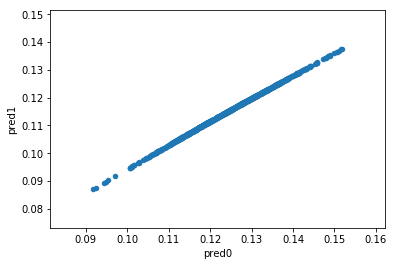

In [113]:
compare.plot.scatter('pred0', 'pred1')

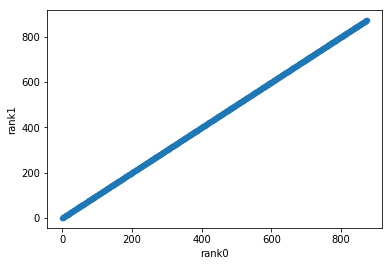

In [114]:
compare.plot.scatter('rank0', 'rank1')

In [77]:
np.sqrt(((compare.pred0 - compare.pred1)**2).mean())

0.0017870536582526423

In [115]:
np.sqrt(((compare.pred0 - compare.pred1)**2).mean())

0.009611300681257269

### Data formating

In [87]:
n_DX = 29
n_PR = 15
DXs = ['DX'+str(n) for n in range(2, n_DX+2)]
PRs = ['PR'+str(n) for n in range(1, n_PR+1)]

In [88]:
DX_cat = ['missing'] + sorted(dx_multi.ICD9CM_CODE)
PR_cat = ['missing'] + sorted(pr_multi.ICD9CM_CODE)
n_DX_cat = len(DX_cat)
n_PR_cat = len(PR_cat)
unclassified = set(dx_multi.loc[dx_multi.CCS_LVL1 == '18', 'ICD9CM_CODE'])
dx_ccs_cat = pd.concat([dx_multi.CCS_LVL1, dx_multi.CCS_LVL2, dx_multi.CCS_LVL3, dx_multi.CCS_LVL4]).astype('category').cat.categories
pr_ccs_cat = pd.concat([pr_multi.CCS_LVL1, pr_multi.CCS_LVL2, pr_multi.CCS_LVL3]).astype('category').cat.categories

DX1_dict = dict(zip(DX_cat, range(len(DX_cat))))
DX_dict = dict(zip(DX_cat, [0] + list(range(len(DX_cat), len(DX_cat)*2))))
PR_dict = dict(zip(PR_cat, [0] + list(range(len(DX_cat)*2-1, len(DX_cat)*2+len(PR_cat)-1))))
code_cat = ['missing']+sorted(dx_multi.ICD9CM_CODE)*2+sorted(pr_multi.ICD9CM_CODE)+sorted(dx_ccs_cat)[1:]*2+sorted(pr_ccs_cat)[1:]
n_code_cat = len(code_cat)    
dx1_ccs_dict = dict(zip(dx_ccs_cat[1:], range(1+len(dx_multi)*2+len(pr_multi), len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat))))
dx_ccs_dict = dict(zip(dx_ccs_cat[1:], range(1+len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat[1:]), 
                                             1+len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat[1:])*2)))
pr_ccs_dict = dict(zip(pr_ccs_cat[1:], range(1+len(dx_multi)*2+len(pr_multi)+len(dx_ccs_cat[1:])*2, n_code_cat)))

In [89]:
all_df = pd.read_csv(path+'cohorts/{}/{}_pred.csv'.format(cohort, cohort), dtype=core_dtypes_pd)

In [90]:
hosp_freq = all_df.HOSP_NRD.value_counts()

In [12]:
len(hosp_freq), sum(hosp_freq>30)

(1107, 868)

In [91]:
hosp_series = all_df['HOSP_NRD'].astype('category')
hosp_cat = hosp_series.cat.categories
hosp_dict = dict(zip(hosp_cat, range(len(hosp_cat))))

In [92]:
tst_key = pd.read_csv(path+'cohorts/{}/tst_key{}.csv'.format(cohort, tst_seed), names = ['KEY_NRD'])
tst_df = all_df.loc[all_df.KEY_NRD.isin(tst_key.KEY_NRD)]
train_df0 = all_df.loc[~all_df.KEY_NRD.isin(tst_key.KEY_NRD)].reset_index()

age_mean = train_df0['AGE'].mean()
age_std = train_df0['AGE'].std()
los_mean = train_df0['LOS'].mean()
los_std = train_df0['LOS'].std()

In [93]:
DX1_array = index_df.DX1.map(DX1_dict).values
DX_df = index_df[DXs]
DX_df = DX_df.fillna('missing')
DX_df[DX_df.isin(['invl', 'incn'])] = 'missing'
DX_df[DX_df.isin(unclassified)] = 'missing'
for dx in DXs:
    DX_df[dx] = DX_df[dx].map(DX_dict)
DX_mat = DX_df.values
PR_df = index_df[PRs]
PR_df = PR_df.fillna('missing')
PR_df[PR_df.isin(['invl', 'incn'])] = 'missing'
for pr in PRs:
    PR_df[pr] = PR_df[pr].map(PR_dict)
PR_mat = PR_df.values
demo_mat = index_df[['AGE', 'FEMALE']].values
demo_mat[:, 0] = (demo_mat[:, 0]-age_mean)/age_std
hosp_array = index_df['HOSP_NRD'].map(hosp_dict).values
pay1_mat = to_categorical(index_df.PAY1.values)[:, 1:]
los_array = (index_df.LOS.values - los_mean)/los_std
ed_mat = to_categorical(index_df.HCUP_ED.values)
zipinc_mat = to_categorical(index_df.ZIPINC_QRTL.values)[:, 1:]
transfer_mat = to_categorical(index_df.SAMEDAYEVENT.values)
other_mat = np.concatenate((demo_mat, pay1_mat, los_array.reshape(los_array.shape+(1,)), 
                                ed_mat, zipinc_mat, transfer_mat), axis=1)

### Model Building

In [100]:
from setsum_layer import SetSum, MaskedSum, MaskedDense, MaskedPooling

In [101]:
code_embed_dim = 200
md_width = 128
fc_width = 512
hosp_embed_dim = 1
dropout = 0.3
batchsize = 512

In [103]:
input_DX1 = Input(shape=(1,))
DX1_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, name='DX1_embed')(input_DX1)
DX1_embed = Reshape((code_embed_dim,))(DX1_embed)
input_DX = Input(shape = (n_DX,))
DX_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, mask_zero=True, name='DX_embed')(input_DX)
DX_embed = MaskedDense(md_width, activation='relu')(DX_embed)
DX_embed = MaskedSum()(DX_embed)
input_PR = Input(shape = (n_PR,))
PR_embed = Embedding(input_dim=n_code_cat, output_dim=code_embed_dim, mask_zero=True, name='PR_embed')(input_PR)
PR_embed = MaskedDense(md_width, activation='relu')(PR_embed)
PR_embed = MaskedSum()(PR_embed)
input_hosp = Input(shape=(1,))
hosp_embed = Embedding(input_dim=len(hosp_cat), output_dim=hosp_embed_dim, input_length=1, name='hosp_embed')(input_hosp)
hosp_embed = Reshape((hosp_embed_dim, ))(hosp_embed)
input_other = Input(shape=(other_mat.shape[1], ))
merged = Concatenate(axis=1)([DX1_embed, DX_embed, PR_embed, hosp_embed, input_other])
x = Dense(fc_width, activation='relu')(merged)
x = Dropout(dropout)(x)
prediction = Dense(2, activation='softmax')(x)
model = Model(inputs=[input_DX1, input_DX, input_PR, input_hosp, input_other], outputs=prediction)

In [104]:
model.load_weights(model_path+'best_{}{}.h5'.format(cohort, tst_seed))

In [105]:
y = model.predict([DX1_array, DX_mat, PR_mat, hosp_array, other_mat], verbose=1)

y_pred = y[:, 1]

191509/191509 [==============================] - 10s 51us/step


In [109]:
national_pred = y_pred.mean()

In [106]:
y_true = adjust_df.readm30.values

{0: 0.732404492704879}

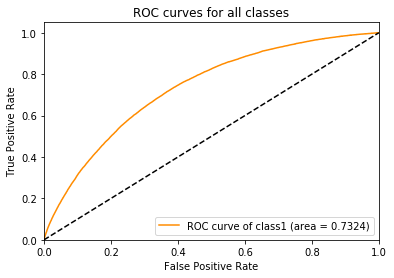

In [107]:
plot_roc(y_pred, y_true)

In [112]:
hosp_embed_layer = [l for l in model.layers if l.name=='hosp_embed'][0]

hosp_embed_mat = hosp_embed_layer.get_weights()[0]

hosp_embed_array = hosp_embed_mat[:, 0]

In [63]:
adjust_df = adjust_df.assign(predicted_score_dl=y_pred)

In [24]:
grouped = adjust_df.groupby('HOSP_NRD')

In [25]:
adjusted_rate = grouped[['readm30', 'predicted_score', 'expected_score', 'predicted_score_dl']].mean()

In [78]:
adjusted_rate = adjusted_rate.assign(N=grouped.size())

In [27]:
adjusted_rate = adjusted_rate.sort_values(by='N', ascending=False)

In [30]:
adjust_df.predicted_score_dl.mean(), adjust_df.readm30.mean(), adjust_df.predicted_score.mean()

(0.11953476071357727, 0.12666245450605454, 0.12489865147974813)

In [68]:
national_observed = adjust_df.readm30.mean()

In [36]:
adjusted_rate.columns = ['Observed', 'Predicted_ME', 'Expected_ME', 'Predicted_DL', 'N']

In [100]:
adjusted_rate.columns = ['Observed', 'Predicted_ME', 'Expected_ME', 'N']

In [101]:
adjusted_rate = adjusted_rate.assign(Adjusted_ME=adjusted_rate.Predicted_ME/adjusted_rate.Expected_ME*national_observed)

In [69]:
hosp_lst = adjusted_rate.HOSP_NRD.values

In [70]:
hosp_lst[:10]

array([12245, 13794, 13108, 11296, 11449, 12888, 11569, 11386, 12616,
       12419])

In [71]:
recycle_pred = []
for i, hosp in enumerate(hosp_lst[:5]):
    hosp_array = np.repeat(hosp_dict[hosp], len(index_df))
    y = model.predict([DX1_array, DX_mat, PR_mat, hosp_array, other_mat], verbose=0)
    y_pred = y[:, 1]
    recycle_pred.append(y_pred.mean())
    print(i)

0
1
2
3
4


In [72]:
recycle_pred

[0.12781878, 0.119579345, 0.12239194, 0.11557904, 0.11595199]

In [47]:
len(recycle_pred)

1107

In [48]:
adjusted_rate = adjusted_rate.assign(Adjusted_DL=recycle_pred)

In [17]:
adjusted_rate0 = adjusted_rate.copy()

In [10]:
adjusted_rate = adjusted_rate0.loc[adjusted_rate0.N>9]

In [18]:
adjusted_rate = adjusted_rate.sort_values('Adjusted_ME')
adjusted_rate = adjusted_rate.assign(Rank_ME = range(len(adjusted_rate)))

adjusted_rate = adjusted_rate.assign(Division_ME = 'middle60')
adjusted_rate.loc[adjusted_rate.Rank_ME<int(len(adjusted_rate)*0.2), 'Division_ME'] = 'top20'
adjusted_rate.loc[adjusted_rate.Rank_ME>int(len(adjusted_rate)*0.8), 'Division_ME'] = 'bottom20'

In [19]:
adjusted_rate = adjusted_rate.sort_values('Adjusted_DL')
adjusted_rate = adjusted_rate.assign(Rank_DL = range(len(adjusted_rate)))

adjusted_rate = adjusted_rate.assign(Division_DL = 'middle60')
adjusted_rate.loc[adjusted_rate.Rank_DL<int(len(adjusted_rate)*0.2), 'Division_DL'] = 'top20'
adjusted_rate.loc[adjusted_rate.Rank_DL>int(len(adjusted_rate)*0.8), 'Division_DL'] = 'bottom20'

In [20]:
adjusted_rate = adjusted_rate.sort_values('Recycled_ME')
adjusted_rate = adjusted_rate.assign(Rank_recycle_ME = range(len(adjusted_rate)))

adjusted_rate = adjusted_rate.assign(Division_recycle_ME = 'middle60')
adjusted_rate.loc[adjusted_rate.Rank_recycle_ME<int(len(adjusted_rate)*0.2), 'Division_recycle_ME'] = 'top20'
adjusted_rate.loc[adjusted_rate.Rank_recycle_ME>int(len(adjusted_rate)*0.8), 'Division_recycle_ME'] = 'bottom20'

In [15]:
adjusted_rate.head(20)

,HOSP_NRD,Observed,Predicted_ME,Expected_ME,Predicted_DL,N,Adjusted_ME,Adjusted_DL,Rank_ME,Division_ME,Rank_DL,Division_DL
857,12513,0.000000,0.098073,0.107894,0.072570,34,0.115133,0.100217,164,top20,0,top20
420,14035,0.045714,0.087958,0.119099,0.084754,175,0.093544,0.101063,2,top20,1,top20
31,11058,0.061667,0.077574,0.104205,0.086588,600,0.094293,0.102124,5,top20,2,top20
269,13967,0.060241,0.092157,0.116396,0.090304,249,0.100285,0.103186,14,top20,3,top20
38,11055,0.095400,0.099371,0.119092,0.104955,587,0.105687,0.103320,38,top20,4,top20
862,13462,0.060606,0.129126,0.141223,0.117283,33,0.115813,0.103486,183,top20,5,top20
593,13008,0.071429,0.100246,0.115616,0.094118,112,0.109824,0.103912,78,top20,6,top20
734,11184,0.046154,0.097535,0.111969,0.080916,65,0.110334,0.103967,85,top20,7,top20
769,12861,0.054545,0.092059,0.097675,0.067970,55,0.119379,0.104242,262,middle60,8,top20
428,13906,0.057803,0.078413,0.094241,0.071936,173,0.105389,0.104713,36,top20,9,top20


In [11]:
adjusted_rate[['HOSP_NRD', 'N', 'Observed', 'Adjusted_ME', 'Adjusted_DL']].tail(20)

,HOSP_NRD,N,Observed,Adjusted_ME,Adjusted_DL
1087,11424,11,0.090909,0.121668,0.110919
1088,12274,11,0.363636,0.128576,0.122766
1089,11456,11,0.090909,0.126595,0.117963
1090,13071,11,0.272727,0.125964,0.117699
1091,12828,11,0.181818,0.128669,0.120154
1092,11997,10,0.000000,0.120680,0.115942
1093,12874,10,0.200000,0.128908,0.112815
1094,13318,10,0.100000,0.124979,0.113105
1095,12066,10,0.200000,0.128936,0.123382
1096,12218,10,0.100000,0.125914,0.120221


In [14]:
adjusted_rate.shape

(1107, 12)

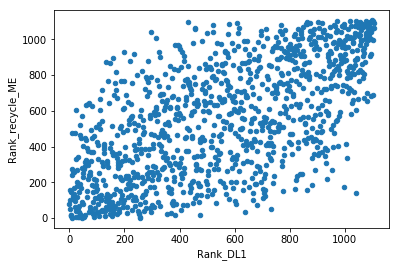

In [37]:
adjusted_rate.plot.scatter('Rank_DL1', 'Rank_recycle_ME')

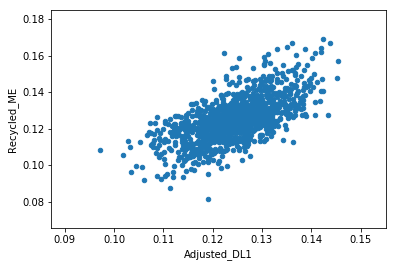

In [38]:
adjusted_rate.plot.scatter('Adjusted_DL1', 'Recycled_ME')

In [39]:
pd.crosstab(adjusted_rate.Division_DL1, adjusted_rate.Division_recycle_ME, margins=True)

Division_recycle_ME,bottom20,middle60,top20,All
Division_DL1,,,,
bottom20,116,103,2,221
middle60,103,456,106,665
top20,2,106,113,221
All,221,665,221,1107


In [18]:
pd.crosstab(adjusted_rate.Division_DL, adjusted_rate.Division_ME, normalize='index')

Division_ME,bottom20,middle60,top20
Division_DL,,,
bottom20,0.542986,0.443439,0.013575
middle60,0.148872,0.708271,0.142857
top20,0.009050,0.434389,0.556561


In [16]:
adjusted_rate = adjusted_rate.assign(rank_diff=adjusted_rate.Rank_ME - adjusted_rate.Rank_DL)

In [17]:
adjusted_rate.sort_values('rank_diff', ascending=False).head()

,HOSP_NRD,Observed,Predicted_ME,Expected_ME,Predicted_DL,N,Adjusted_ME,Adjusted_DL,Rank_ME,Division_ME,Rank_DL,Division_DL,rank_diff
301,13042,0.141026,0.133393,0.123684,0.130901,234,0.136605,0.112552,908,bottom20,151,top20,757
329,11973,0.150000,0.139472,0.130377,0.143659,220,0.135498,0.112926,876,middle60,169,top20,707
562,11943,0.139344,0.111421,0.103801,0.125417,122,0.135961,0.113867,891,bottom20,209,top20,682
213,13180,0.161972,0.135559,0.111793,0.127514,284,0.153590,0.116939,1074,bottom20,397,middle60,677
568,13408,0.159664,0.133056,0.117297,0.125535,119,0.143680,0.116379,1008,bottom20,362,middle60,646


In [50]:
adjusted_rate.to_csv(path+'cohorts/{}/adjusted_rate.csv'.format(cohort))

In [24]:
adjusted_rate = pd.read_csv(path+'cohorts/{}/adjusted_rate.csv'.format(cohort))

In [138]:
recycle_DL = pd.read_csv(path+'cohorts/{}/recyc_pred_{}.csv'.format(cohort, 0))
recycle_DL.columns = ['Adjusted_index{}'.format(0), 'HOSP_NRD']
for tst_seed in range(1, 10):
    recyc = pd.read_csv(path+'cohorts/{}/recyc_pred_{}.csv'.format(cohort, tst_seed))
    recyc.columns = ['Adjusted_index{}'.format(tst_seed), 'HOSP_NRD']
    recycle_DL = pd.merge(recycle_DL, recyc, on='HOSP_NRD')

In [139]:
for tst_seed in range(7):
    recyc = pd.read_csv(path+'cohorts/{}/recyc_pred_tst{}.csv'.format(cohort, tst_seed))
    recyc.columns = ['Adjusted_tst{}'.format(tst_seed), 'HOSP_NRD']
    recycle_DL = pd.merge(recycle_DL, recyc, on='HOSP_NRD')

In [80]:
recycle_DL = recycle_DL.assign(mean=recycle_DL[['Adjusted_DL'+str(s) for s in range(10)]].mean(axis=1))
recycle_DL = recycle_DL.assign(std=recycle_DL[['Adjusted_DL'+str(s) for s in range(10)]].std(axis=1)/np.sqrt(1))
recycle_DL = recycle_DL.assign(upper=recycle_DL['mean']+1.96*recycle_DL['std'])
recycle_DL = recycle_DL.assign(lower=recycle_DL['mean']-1.96*recycle_DL['std'])

In [140]:
recycle_DL.head()

,Adjusted_index0,HOSP_NRD,Adjusted_index1,Adjusted_index2,Adjusted_index3,Adjusted_index4,Adjusted_index5,Adjusted_index6,Adjusted_index7,Adjusted_index8,Adjusted_index9,Adjusted_tst0,Adjusted_tst1,Adjusted_tst2,Adjusted_tst3,Adjusted_tst4,Adjusted_tst5,Adjusted_tst6
0,0.111387,11006.0,0.117523,0.120643,0.106672,0.118943,0.125235,0.127023,0.108597,0.106732,0.119385,0.110114,0.115654,0.120461,0.105349,0.117297,0.123791,0.125217
1,0.115136,11010.0,0.118052,0.119817,0.109564,0.117154,0.109042,0.123234,0.104473,0.097824,0.110803,0.113841,0.116177,0.119639,0.108220,0.115513,0.107679,0.121456
2,0.111795,11011.0,0.108583,0.125113,0.110101,0.115699,0.118537,0.115928,0.107616,0.103374,0.111845,0.110519,0.106824,0.124908,0.108752,0.114063,0.117123,0.114209
3,0.128108,11013.0,0.133123,0.137423,0.132450,0.137320,0.127113,0.141172,0.133023,0.146313,0.130289,0.126742,0.131081,0.137156,0.130943,0.135636,0.125661,0.139268
4,0.115302,11014.0,0.126566,0.117974,0.112363,0.114952,0.115864,0.129919,0.115519,0.114341,0.115896,0.114006,0.124595,0.117805,0.110998,0.113317,0.114464,0.128092


In [119]:
recycle_DL = recycle_DL.assign(intercept0=recycle_DL.HOSP_NRD.apply(lambda x:hosp_embed_array[hosp_dict[x]]))

In [22]:
recycle_DL.upper.min(), recycle_DL.lower.max()

(0.10371397972452481, 0.1361400854459275)

In [110]:
sum(recycle_DL.upper<national_pred), sum(recycle_DL.lower>national_pred)

(21, 28)

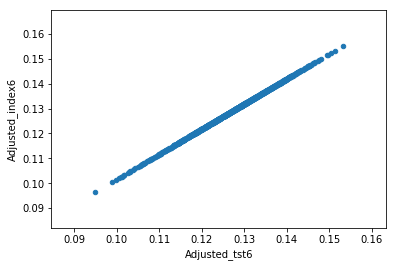

In [146]:
recycle_DL.plot.scatter('Adjusted_tst6', 'Adjusted_index6')

In [141]:
compare = pd.merge(adjusted_rate[['HOSP_NRD', 'Adjusted_ME']], recycle_DL[['HOSP_NRD', 'mean']], on='HOSP_NRD')

/sw/lsa/centos7/python-anaconda-arc-connect/created-20170421/lib/python3.5/site-packages/IPython/core/interactiveshell.py:2961: FutureWarning: 'HOSP_NRD' is both an index level and a column label.
Defaulting to column, but this will raise an ambiguity error in a future version
  exec(code_obj, self.user_global_ns, self.user_ns)


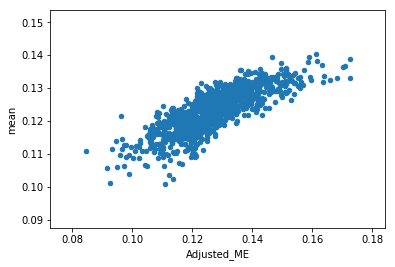

In [142]:
compare.plot.scatter('Adjusted_ME', 'mean')

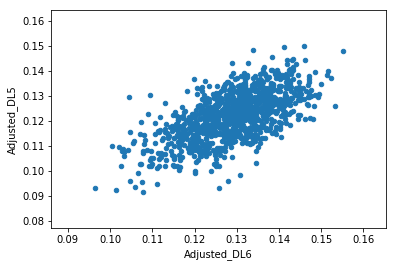

In [124]:
recycle_DL.plot.scatter('Adjusted_DL6', 'Adjusted_DL5')

In [31]:
adjusted_rate = pd.merge(adjusted_rate, recycle_DL1, on='HOSP_NRD')

In [32]:
adjusted_rate = adjusted_rate.sort_values('Adjusted_DL1')
adjusted_rate = adjusted_rate.assign(Rank_DL1 = range(len(adjusted_rate)))

adjusted_rate = adjusted_rate.assign(Division_DL1 = 'middle60')
adjusted_rate.loc[adjusted_rate.Rank_DL1<int(len(adjusted_rate)*0.2), 'Division_DL1'] = 'top20'
adjusted_rate.loc[adjusted_rate.Rank_DL1>int(len(adjusted_rate)*0.8), 'Division_DL1'] = 'bottom20'

In [41]:
adjusted_rate[['Adjusted_DL', 'Adjusted_DL1']].describe()

,Adjusted_DL,Adjusted_DL1
count,1107.000000,1107.000000
mean,0.119030,0.124436
std,0.005857,0.007482
min,0.100217,0.097055
25%,0.115115,0.119554
50%,0.119223,0.124456
75%,0.122996,0.129663
max,0.134095,0.145435


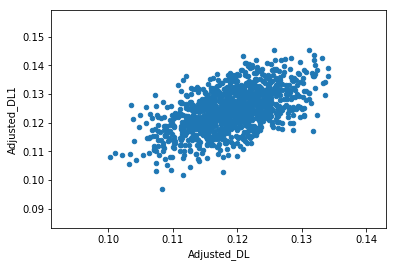

In [33]:
adjusted_rate.plot.scatter('Adjusted_DL', 'Adjusted_DL1')

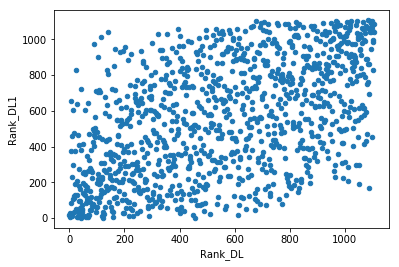

In [34]:
adjusted_rate.plot.scatter('Rank_DL', 'Rank_DL1')

In [36]:
pd.crosstab(adjusted_rate.Division_DL, adjusted_rate.Division_DL1, margins=True)

Division_DL1,bottom20,middle60,top20,All
Division_DL,,,,
bottom20,95,123,3,221
middle60,118,434,113,665
top20,8,108,105,221
All,221,665,221,1107


## Inference

In [41]:
from sklearn.metrics import cohen_kappa_score
from scipy.stats import spearmanr

### Mixed Effect Model

In [6]:
cohort = 'ami'
split_seed = 4
train_idx = 1

In [10]:
train_df = pd.read_csv(path+'cohorts30/{}/inference/index_split{}_{}.csv'.format(cohort, split_seed, train_idx), dtype=core_dtypes_pd)

In [11]:
hosp_freq = train_df.HOSP_NRD.value_counts()

In [10]:
random_effects = pd.read_csv(path+'cohorts30/{}/inference/adjusted_ME{}{}.csv'.format(cohort, split_seed, train_idx))

random_effects = random_effects.assign(upper = random_effects.random_effects + 1.96*random_effects.postVar.apply(np.sqrt))
random_effects = random_effects.assign(lower = random_effects.random_effects - 1.96*random_effects.postVar.apply(np.sqrt))

random_effects = random_effects.assign(outlier = 'not_outlier')
random_effects.loc[random_effects.upper < 0, 'outlier'] = 'good'
random_effects.loc[random_effects.lower > 0, 'outlier'] = 'bad'

In [32]:
random_effects.shape

(874, 6)

In [33]:
random_effects = pd.merge(random_effects, adjusted_rate[['HOSP_NRD', 'N']], on='HOSP_NRD')

In [11]:
random_effects.head()

,Unnamed: 0,HOSP_NRD,random_effects,postVar,readm30,predicted_score,expected_score,Adjusted_ME,upper,lower,outlier
0,1,11006,-0.113801,0.031926,0.079545,0.109325,0.120507,0.114044,0.236408,-0.464011,not_outlier
1,2,11010,-0.233280,0.024963,0.067308,0.093135,0.114016,0.102686,0.076394,-0.542954,not_outlier
2,3,11011,-0.111712,0.035545,0.111111,0.182570,0.198917,0.115378,0.257814,-0.481239,not_outlier
3,4,11013,0.195363,0.019281,0.178261,0.158701,0.135643,0.147078,0.467519,-0.076792,not_outlier
4,5,11014,-0.100615,0.019670,0.097403,0.104925,0.114352,0.115346,0.174275,-0.375504,not_outlier


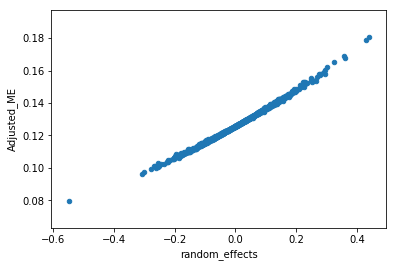

In [12]:
random_effects.plot.scatter('random_effects', 'Adjusted_ME')

In [13]:
random_effects.outlier.value_counts()

not_outlier    863
bad              9
good             2
Name: outlier, dtype: int64

In [7]:
split_seed = 3

In [8]:
RE_compare = pd.DataFrame()
for train_idx in [1,2]:
    random_effects = pd.read_csv(path+'cohorts30/{}/inference/adjusted_ME{}{}.csv'.format(cohort, split_seed, train_idx))

    random_effects = random_effects.assign(upper = random_effects.random_effects + 1.96*random_effects.postVar.apply(np.sqrt))
    random_effects = random_effects.assign(lower = random_effects.random_effects - 1.96*random_effects.postVar.apply(np.sqrt))

    random_effects = random_effects.assign(outlier = 'not_outlier')
    random_effects.loc[random_effects.upper < 0, 'outlier'] = 'good'
    random_effects.loc[random_effects.lower > 0, 'outlier'] = 'bad'
    
    random_effects = random_effects.sort_values('random_effects')
    random_effects = random_effects.assign(rank=range(len(random_effects)))
    
    to_merge = random_effects[['HOSP_NRD', 'outlier', 'random_effects', 'Adjusted_ME', 'rank']]
    to_merge.columns = ['HOSP_NRD', 'outlier'+str(train_idx), 'RE'+str(train_idx), 'Adjusted_ME'+str(train_idx), 'rank'+str(train_idx)]
    
    try:
        RE_compare = pd.merge(RE_compare, to_merge, on='HOSP_NRD')
    except KeyError:
        RE_compare = to_merge

In [12]:
RE_compare = RE_compare.assign(N=RE_compare.HOSP_NRD.apply(lambda x:hosp_freq[x]))

In [40]:
RE_compare.head()

,HOSP_NRD,outlier1,RE1,Adjusted_ME1,rank1,outlier2,RE2,Adjusted_ME2,rank2,N
0,12419,good,-0.431546,0.086922,0,good,-0.353054,0.093917,0,406
1,13344,good,-0.370618,0.091113,1,not_outlier,0.042965,0.130331,575,164
2,12393,not_outlier,-0.319726,0.097181,2,not_outlier,-0.205717,0.107036,24,82
3,13321,not_outlier,-0.284808,0.097148,3,not_outlier,-0.159138,0.109834,59,298
4,11614,not_outlier,-0.257920,0.100061,4,not_outlier,-0.077580,0.118001,197,251


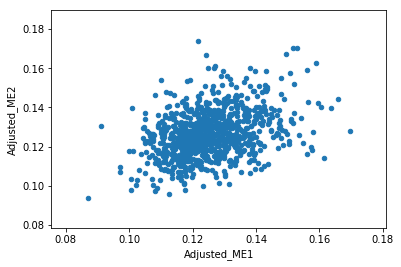

In [13]:
RE_compare.loc[RE_compare.N>2].plot.scatter('Adjusted_ME1', 'Adjusted_ME2')

In [18]:
mean_change = []
for n_sub in range(1, 400, 10):
    topbottom = RE_compare.loc[(RE_compare.rank1<n_sub)|(RE_compare.rank1>=len(RE_compare)-n_sub)|
                           (RE_compare.rank2<n_sub)|(RE_compare.rank2>=len(RE_compare)-n_sub)]
    mean_change.append(np.mean(np.abs(topbottom.rank1 - topbottom.rank2))/len(RE_compare))

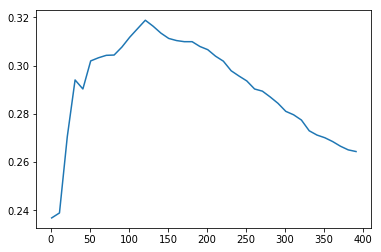

In [19]:
plt.plot(range(1, 400, 10), mean_change)

In [43]:
spearmanr(RE_compare.rank1.values, RE_compare.rank2.values)

SpearmanrResult(correlation=0.3304890734231365, pvalue=1.0179203761454458e-23)

In [76]:
spearmanr(np.random.choice(list(range(1000)), 100), np.random.choice(list(range(1000)), 100))

SpearmanrResult(correlation=-0.03280936364669397, pvalue=0.7458956773375924)

In [34]:
cohen_kappa_score(RE_compare.outlier1, RE_compare.outlier2)

0.29861792242532326

In [35]:
pd.crosstab(RE_compare.outlier1, RE_compare.outlier2, margins=True)

outlier2,bad,good,not_outlier,All
outlier1,,,,
bad,3,0,8,11
good,0,1,1,2
not_outlier,8,1,852,861
All,11,2,861,874


In [22]:
agree_scores = []
for i in range(10):
    for j in range(i):
        agree_scores.append(cohen_kappa_score(RE_compare['outlier'+str(j)], RE_compare['outlier'+str(i)]))

In [24]:
np.mean(agree_scores)

0.7163717878296532

### DL model

In [28]:
tst_seed = 0

In [29]:
recycle_pred = pd.read_csv(path+'cohorts30/{}/recyc_pred_allval_tst{}.csv'.format(cohort, tst_seed))

In [30]:
recycle_pred = recycle_pred.assign(mean=recycle_pred[['recycle_pred'+str(j) for j in range(9)]].mean(axis=1))
recycle_pred = recycle_pred.assign(std=recycle_pred[['recycle_pred'+str(j) for j in range(9)]].std(axis=1))

In [35]:
recycle_pred = recycle_pred.assign(upper=recycle_pred['mean']+1.96*recycle_pred['std'])
recycle_pred = recycle_pred.assign(lower=recycle_pred['mean']-1.96*recycle_pred['std'])

In [39]:
recycle_pred = pd.merge(recycle_pred, adjusted_rate[['HOSP_NRD', 'N']], on='HOSP_NRD')

In [64]:
national_mean = recycle_pred['mean'].mean()

In [68]:
recycle_pred = recycle_pred.assign(outlier='not_outlier')
recycle_pred.loc[recycle_pred.upper<national_mean, 'outlier'] = 'good'
recycle_pred.loc[recycle_pred.lower>national_mean, 'outlier'] = 'bad'

In [69]:
recycle_pred.outlier.value_counts()

not_outlier    753
bad             62
good            59
Name: outlier, dtype: int64

In [30]:
recycle_pred.head()

,recycle_pred0,recycle_pred1,recycle_pred2,recycle_pred3,recycle_pred4,recycle_pred5,recycle_pred6,recycle_pred7,recycle_pred8,HOSP_NRD
0,0.122879,0.119591,0.109598,0.111319,0.114096,0.113663,0.111695,0.092948,0.103654,11006.0
1,0.122387,0.108584,0.111672,0.112634,0.106399,0.109547,0.109125,0.109045,0.111632,11010.0
2,0.120659,0.106689,0.093146,0.109774,0.115128,0.116125,0.112901,0.100389,0.106800,11011.0
3,0.136752,0.136877,0.142795,0.134194,0.136740,0.131593,0.139838,0.139100,0.143648,11013.0
4,0.120044,0.114468,0.117568,0.116837,0.115465,0.116346,0.125638,0.111803,0.113436,11014.0


In [99]:
DL_compare = pd.DataFrame()
for tst_seed in list(range(7))+[8, 9]:
    recycle_pred = pd.read_csv(path+'cohorts30/{}/recyc_pred_allval_tst{}.csv'.format(cohort, tst_seed))
    recycle_pred = recycle_pred.assign(mean=recycle_pred[['recycle_pred'+str(j) for j in range(9)]].mean(axis=1))
    recycle_pred = recycle_pred.assign(std=recycle_pred[['recycle_pred'+str(j) for j in range(9)]].std(axis=1))
    recycle_pred = recycle_pred.assign(upper=recycle_pred['mean']+1.96*recycle_pred['std'])
    recycle_pred = recycle_pred.assign(lower=recycle_pred['mean']-1.96*recycle_pred['std'])
    national_mean = recycle_pred['mean'].mean()
    recycle_pred = recycle_pred.assign(outlier='not_outlier')
    recycle_pred.loc[recycle_pred.upper<national_mean, 'outlier'] = 'good'
    recycle_pred.loc[recycle_pred.lower>national_mean, 'outlier'] = 'bad'
    to_merge = recycle_pred[['HOSP_NRD', 'mean', 'outlier', 'recycle_pred1']]
    to_merge.columns = ['HOSP_NRD', 'recyc_pred'+str(tst_seed), 'outlier'+str(tst_seed), 'recyc_sample'+str(tst_seed)]
    try:
        DL_compare = pd.merge(DL_compare, to_merge, on='HOSP_NRD')
    except KeyError:
        DL_compare = to_merge.copy()

In [31]:
DL_compare = pd.DataFrame()
for tst_seed in range(10):
    recycle_pred = pd.read_csv(path+'cohorts30/{}/recyc_pred_allval_tst{}.csv'.format(cohort, tst_seed))
    recycle_pred = recycle_pred.assign(mean=recycle_pred[['recycle_pred'+str(j) for j in range(9)]].mean(axis=1))    
    to_merge = recycle_pred[['HOSP_NRD', 'mean']]
    to_merge.columns = ['HOSP_NRD', 'recyc_pred'+str(tst_seed)]
    try:
        DL_compare = pd.merge(DL_compare, to_merge, on='HOSP_NRD')
    except KeyError:
        DL_compare = to_merge.copy()

In [33]:
DL_compare = DL_compare.assign(std=DL_compare[['recyc_pred'+str(j) for j in range(10)]].std(axis=1))

In [41]:
DL_compare = pd.merge(DL_compare, adjusted_rate[['HOSP_NRD', 'N']], on='HOSP_NRD')

In [42]:
DL_compare.head()

,HOSP_NRD,recyc_pred0,recyc_pred1,recyc_pred2,recyc_pred3,recyc_pred4,recyc_pred5,recyc_pred6,recyc_pred7,recyc_pred8,recyc_pred9,std,N
0,11006.0,0.111049,0.112403,0.116999,0.109504,0.115585,0.118185,0.114876,0.114679,0.112865,0.115293,0.002677,177
1,11010.0,0.111225,0.109125,0.106838,0.114990,0.110846,0.115588,0.113129,0.115816,0.112575,0.110401,0.002932,416
2,11011.0,0.109068,0.103413,0.117116,0.109008,0.110622,0.115907,0.115083,0.114967,0.112329,0.115024,0.004236,71
3,11013.0,0.137949,0.133529,0.139433,0.136706,0.139706,0.140183,0.133557,0.128460,0.143059,0.137313,0.004190,459
4,11014.0,0.116845,0.117579,0.117034,0.116356,0.118270,0.120149,0.122009,0.110831,0.118780,0.118029,0.002910,617


In [46]:
DL_compare = DL_compare.assign(sqrt_inv=1/np.sqrt(DL_compare.N))

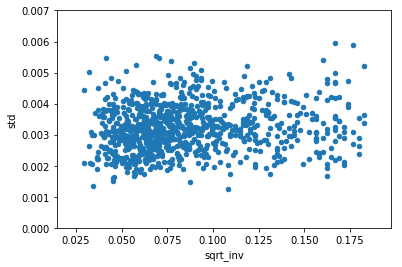

In [47]:
DL_compare.plot.scatter('sqrt_inv', 'std', ylim=(0, 0.007))

In [104]:
pd.crosstab(DL_compare.outlier1, DL_compare.outlier2, margins=True)

outlier2,bad,good,not_outlier,All
outlier1,,,,
bad,9,0,10,19
good,0,11,9,20
not_outlier,10,9,816,835
All,19,20,835,874


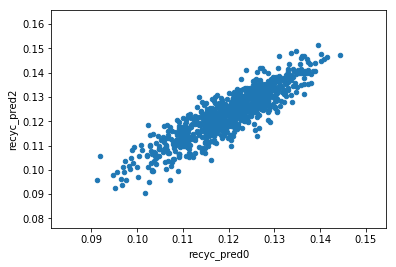

In [100]:
DL_compare.plot.scatter('recyc_pred0', 'recyc_pred2')

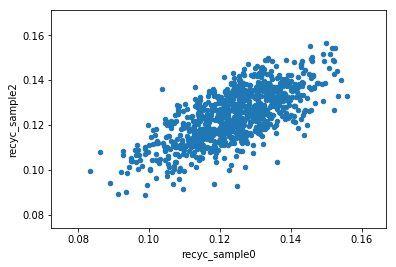

In [101]:
DL_compare.plot.scatter('recyc_sample0', 'recyc_sample2')

In [85]:
tst_seeds = list(range(7))+[8, 9]

In [105]:
DL_agree = []
for i, si in enumerate(tst_seeds):
    for sj in tst_seeds[:i]:
        DL_agree.append(cohen_kappa_score(DL_compare['outlier'+str(sj)], DL_compare['outlier'+str(si)]))

In [106]:
np.mean(DL_agree)

0.5313198765619466

In [45]:
compare = pd.merge(adjusted_rate[['HOSP_NRD', 'N', 'Adjusted_ME']], recycle_pred[['HOSP_NRD', 'mean']], on='HOSP_NRD')

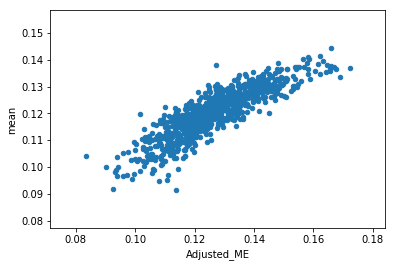

In [46]:
compare.plot.scatter('Adjusted_ME', 'mean')

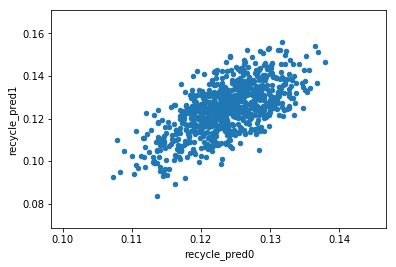

In [63]:
recycle_pred.loc[recycle_pred.N>50].plot.scatter('recycle_pred0', 'recycle_pred1')

In [ ]:
DL_compare

### Model Average

In [5]:
cohort = 'ami'
tst_seed = 1
val_seed = 0

In [21]:
auc_df = pd.read_csv(path+'cohorts30/{}/model_avg/auc_auc{}{}.csv'.format(cohort, tst_seed, val_seed))

In [6]:
pred_df0 = pd.read_csv(path+'cohorts30/{}/model_avg/pred_auc{}{}.csv'.format(cohort, tst_seed, 0))

In [7]:
pred_df1 = pd.read_csv(path+'cohorts30/{}/model_avg/pred_auc{}{}.csv'.format(cohort, tst_seed, 1))

In [14]:
auc_df

,auc0,auc1,auc2,auc3,auc4,auc5,auc6,auc7,auc8,auc9,...,auc16,auc17,auc18,auc19,auc20,auc21,auc22,auc23,auc24,auc_avg
0,0.719872,0.719309,0.719006,0.718547,0.71957,0.719518,0.718877,0.718824,0.717976,0.71982,...,0.718562,0.717749,0.719735,0.719909,0.717857,0.719932,0.719415,0.718842,0.719085,0.720689


In [31]:
auc_avg = []
auc_mean = []
auc_std = []
for val_seed in range(9):
    auc_df = pd.read_csv(path+'cohorts30/{}/model_avg/auc_auc{}{}.csv'.format(cohort, tst_seed, val_seed))
    auc_avg.append(auc_df.auc_avg.values[0])
    auc_mean.append(np.mean(auc_df.iloc[0].values[:-1]))
    auc_std.append(np.std(auc_df.iloc[0].values[:-1]))

In [25]:
np.mean(auc_avg), np.mean(auc_mean), np.mean(auc_std)

(0.7208923853605391, 0.7192564400627358, 0.0007330162316364413)

In [27]:
np.mean(auc_avg), np.mean(auc_mean), np.mean(auc_std)

(0.7206106626862288, 0.7190050981617052, 0.0007655666848341432)

In [8]:
pred_df0.head()

,pred0,pred1,pred2,pred3,pred4,pred5,pred6,pred7,pred8,pred9,...,pred16,pred17,pred18,pred19,pred20,pred21,pred22,pred23,pred24,pred_avg
0,0.162252,0.114345,0.135777,0.149597,0.139015,0.122746,0.155796,0.123529,0.130514,0.127393,...,0.137972,0.142270,0.116610,0.134052,0.116603,0.136210,0.140518,0.122134,0.154558,0.132150
1,0.145372,0.108558,0.140535,0.135537,0.127568,0.137383,0.147492,0.143889,0.145915,0.140725,...,0.147379,0.124959,0.127931,0.143997,0.124328,0.124282,0.145710,0.125237,0.113254,0.134118
2,0.025653,0.024955,0.023265,0.026290,0.025391,0.024871,0.025943,0.024780,0.024847,0.027431,...,0.029341,0.028070,0.027350,0.028088,0.023470,0.024525,0.030098,0.025047,0.025556,0.026132
3,0.366268,0.311505,0.374964,0.313760,0.327067,0.343134,0.342701,0.396603,0.356680,0.298974,...,0.319656,0.317326,0.308182,0.385428,0.323560,0.287847,0.342468,0.306045,0.334558,0.332657
4,0.107280,0.107621,0.105747,0.164042,0.089425,0.138897,0.123713,0.128910,0.124437,0.146779,...,0.119093,0.110289,0.131528,0.123190,0.120626,0.102096,0.158116,0.118415,0.134456,0.121762


In [9]:
pred_df0.columns = ['pred0_'+str(j) for j in range(25)]+['avg0']
pred_df1.columns = ['pred1_'+str(j) for j in range(25)]+['avg1']

In [10]:
compare = pd.concat([pred_df0, pred_df1], axis=1)

In [11]:
compare = compare.assign(avg1_5f=compare[['pred1_'+str(j) for j in range(5)]].mean(axis=1))

In [13]:
compare = compare.assign(avg1_20f=compare[['pred1_'+str(j) for j in range(20)]].mean(axis=1))

In [66]:
compare.head()

,pred0_0,pred0_1,pred0_2,pred0_3,pred0_4,pred0_5,pred0_6,pred0_7,pred0_8,pred0_9,...,pred1_19,pred1_20,pred1_21,pred1_22,pred1_23,pred1_24,avg1,avg0_10f,avg0_10l,avg0_5l
0,0.162252,0.114345,0.135777,0.149597,0.139015,0.122746,0.155796,0.123529,0.130514,0.127393,...,0.151064,0.125698,0.138643,0.129101,0.115849,0.136384,0.137242,0.136096,0.127276,0.131996
1,0.145372,0.108558,0.140535,0.135537,0.127568,0.137383,0.147492,0.143889,0.145915,0.140725,...,0.139593,0.144945,0.146768,0.142364,0.139332,0.148561,0.144099,0.137297,0.134718,0.143081
2,0.025653,0.024955,0.023265,0.026290,0.025391,0.024871,0.025943,0.024780,0.024847,0.027431,...,0.023391,0.022535,0.025094,0.022981,0.021883,0.020282,0.023333,0.025343,0.027117,0.025574
3,0.366268,0.311505,0.374964,0.313760,0.327067,0.343134,0.342701,0.396603,0.356680,0.298974,...,0.327975,0.292404,0.306621,0.338890,0.311509,0.343591,0.335581,0.343166,0.329029,0.347618
4,0.107280,0.107621,0.105747,0.164042,0.089425,0.138897,0.123713,0.128910,0.124437,0.146779,...,0.116276,0.141644,0.116331,0.110200,0.102858,0.172948,0.128027,0.123685,0.117348,0.132547


In [24]:
np.mean([np.sqrt(((compare['pred1_'+str(j)] - compare.avg1)**2).mean()) for j in range(25)])

0.013401288578754294

In [27]:
np.sqrt(((compare.avg1_20f - compare.avg1)**2).mean())

0.0012602963598482822

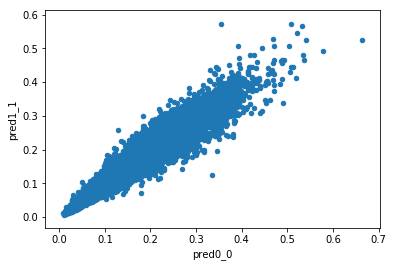

In [52]:
compare.plot.scatter('pred0_0', 'pred1_1')

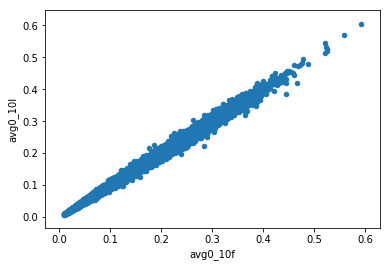

In [60]:
compare.plot.scatter('avg0_10f', 'avg0_10l')

## Diagnosis for abnormal hospitals

In [18]:
hosp1 = index_df.loc[index_df.HOSP_NRD==13042]

In [20]:
comorbs = [c for c in index_df.columns if c.startswith('CM_')]

In [33]:
pd.concat([hosp1[comorbs].mean(), index_df[comorbs].mean()], axis=1)

,0,1
CM_AIDS,0.000000,0.001426
CM_ALCOHOL,0.072650,0.035330
CM_ANEMDEF,0.196581,0.165893
CM_ARTH,0.029915,0.026025
CM_BLDLOSS,0.000000,0.007185
CM_CHF,0.008547,0.004741
CM_CHRNLUNG,0.205128,0.205108
CM_COAG,0.025641,0.054447
CM_DEPRESS,0.085470,0.081098
CM_DM,0.388889,0.298633


In [38]:
cooccur_hosp1 = np.dot(hosp1[comorbs].values.transpose(), hosp1[comorbs].values)/len(hosp1)

In [42]:
cooccur_index = np.dot(index_df[comorbs].values.transpose(), index_df[comorbs].values)/len(index_df)

In [43]:
diff = pd.DataFrame(data=(cooccur_hosp1-cooccur_index), index=comorbs, columns=comorbs)

In [50]:
np.where(diff.values==diff.values.max())

(array([9]), array([9]))

In [52]:
cooccur_hosp1[9, 12]

0.32051282051282054

In [53]:
cooccur_index[9, 12]

0.24922588494535505

In [51]:
diff

,CM_AIDS,CM_ALCOHOL,CM_ANEMDEF,CM_ARTH,CM_BLDLOSS,CM_CHF,CM_CHRNLUNG,CM_COAG,CM_DEPRESS,CM_DM,...,CM_OBESE,CM_PARA,CM_PERIVASC,CM_PSYCH,CM_PULMCIRC,CM_RENLFAIL,CM_TUMOR,CM_ULCER,CM_VALVE,CM_WGHTLOSS
CM_AIDS,-0.001426,-0.000089,-0.000324,-0.000031,-0.000005,-0.000010,-0.000266,-0.000131,-0.000251,-0.000355,...,-0.000094,-0.000021,-0.000120,-0.000099,-0.000005,-0.000355,-0.000021,0.000000,-0.000005,-0.000057
CM_ALCOHOL,-0.000089,0.037320,0.011925,-0.000486,-0.000240,-0.000198,0.016028,-0.003415,0.009416,0.010013,...,0.003096,-0.000407,0.004041,0.002263,-0.000042,0.004730,-0.000428,-0.000021,-0.000052,0.002702
CM_ANEMDEF,-0.000324,0.011925,0.030688,0.002469,-0.001493,-0.001551,-0.002312,-0.018025,0.000520,0.046577,...,-0.002431,-0.000478,-0.013127,-0.006099,-0.000366,0.012402,-0.004099,-0.000141,-0.000574,0.006739
CM_ARTH,-0.000031,-0.000486,0.002469,0.003890,-0.000277,-0.000073,-0.007227,-0.001828,0.001177,0.018889,...,0.004297,-0.000418,0.000409,-0.000841,-0.000031,0.006544,-0.000433,-0.000016,-0.000031,-0.001159
CM_BLDLOSS,-0.000005,-0.000240,-0.001493,-0.000277,-0.007185,-0.000131,-0.002104,-0.000893,-0.000689,-0.002334,...,-0.001269,-0.000178,-0.001650,-0.000219,-0.000010,-0.002882,-0.000334,-0.000016,-0.000057,-0.000512
CM_CHF,-0.000010,-0.000198,-0.001551,-0.000073,-0.000131,0.003806,-0.001316,0.003532,-0.000345,-0.001478,...,-0.000862,-0.000319,-0.000966,-0.000157,-0.000595,0.006563,-0.000183,0.000000,-0.001050,-0.000877
CM_CHRNLUNG,-0.000266,0.016028,-0.002312,-0.007227,-0.002104,-0.001316,0.000020,-0.009240,0.001209,0.015111,...,0.000873,-0.003911,-0.007136,0.003912,-0.000334,-0.009325,-0.004705,-0.000078,-0.000423,-0.004269
CM_COAG,-0.000131,-0.003415,-0.018025,-0.001828,-0.000893,0.003532,-0.009240,-0.028806,-0.000222,-0.003529,...,-0.001087,-0.001342,-0.010454,-0.001723,-0.000157,-0.013214,-0.001201,-0.000021,-0.000345,-0.003781
CM_DEPRESS,-0.000251,0.009416,0.000520,0.001177,-0.000689,-0.000345,0.001209,-0.000222,0.004372,0.009119,...,-0.004735,-0.002047,-0.003050,0.002263,-0.000073,0.007997,-0.001206,-0.000010,-0.000146,0.001449
CM_DM,-0.000355,0.010013,0.046577,0.018889,-0.002334,-0.001478,0.015111,-0.003529,0.009119,0.090255,...,0.022665,-0.001643,0.017427,0.000620,-0.000282,0.027662,-0.004261,-0.000094,-0.000496,-0.006433
